# Project 1

Authors: Naomi Buell and Richie Rivera

## Instructions

*For your first project, you are asked to*

*1. Identify and load a network dataset that has some categorical information available for each node.*

*2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.*

*3. Compare your centrality measures across your categorical groups.*

*For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.*

## Step 1: Identify and load One Piece interaction network dataset

For this assignment, we use the [One Piece Interaction](https://github.com/jonaszeu/one-piece-interaction-data) dataset from jonaszeu on github. It was created by scraping a wiki of the show and documenting every interaction between two characters and categorizes it into an interaction type (Communication, Confrontation, Cooperation, etc). This dataset is available in a few different ways but we will be using the `.csv` that is created as our data source.

In this dataset, each row corresponds to one interaction (edge) between two characters (nodes). For each node, the available categorical variables are: 
- `Interaction`, which describes the type of interaction between the two characters (e.g. Perception, Communication, Confrontation, Cooperation, Emotional, Indirect, Physical, or Other),
- `Saga`, which describes the saga in which the interaction took place (e.g. East Blue, Alabasta, Sky Island, etc.),
- `Arc`, which describes the smaller story arc in which the interaction took place (e.g. Romance Dawn, Orange Town, Syrup Village, etc.), and
- `Filler`, which indicates whether the interaction took place in a filler episode (True or False).

In this notebook, we load the data described above and calculate characters' degree centrality to predicting whether they are a central character for a given story arc.



First, we import Libraries. We use NetworkX for graph analysis, pandas for data manipulation, and matplotlib for visualization.



In [23]:
# Import libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import numpy as np

Next, we load the Dataset. We read in the CSV file directly from the GitHub repository (using the following url: 'https://raw.githubusercontent.com/jonaszeu/one-piece-interaction-data/refs/heads/main/one_piece_interactions_1-1085.csv') into a pandas DataFrame and preview the data and its shape.

In [2]:
# Load the dataset directly from github
op_url = 'https://raw.githubusercontent.com/jonaszeu/one-piece-interaction-data/refs/heads/main/one_piece_interactions_1-1085.csv'
op_df = pd.read_csv(op_url)

# Make the Character Names "proper"
for e in ['Character 1', 'Character 2']: op_df[e] = op_df[e].str.title()

# Show a sample of the data
op_df.head()

,Episode,Character 1,Character 2,Interaction,Saga,Arc,Filler
0,1,Luffy,Sailors On A Cruise Ship,Perception,East Blue Saga,Romance Dawn,False
1,1,Luffy,Alvida Pirates,Confrontation,East Blue Saga,Romance Dawn,False
2,1,Luffy,Koby,Communication,East Blue Saga,Romance Dawn,False
3,1,Luffy,Koby,Cooperation,East Blue Saga,Romance Dawn,False
4,1,Koby,Alvida,Confrontation,East Blue Saga,Romance Dawn,False


In [3]:
# Get a total number of characters to get all the nodes
op_unique_characters = set(list(op_df['Character 1']) + list(op_df['Character 2']))

# Print information on the dataset
print(f"{op_df.shape[0]:,} Edges (i.e., interactions) \n{len(op_unique_characters):,} Nodes (i.e., characters)")

28,185 Edges (i.e., interactions) 
1,448 Nodes (i.e., characters)


Here, we visualize a subset of the data--just the Romance Dawn arc--using NetworkX, with characters as nodes and interactions as edges, and display cooperation and confrontation `Interaction` attributes in blue and red respectively, and weighting edges based on interaction frequency.

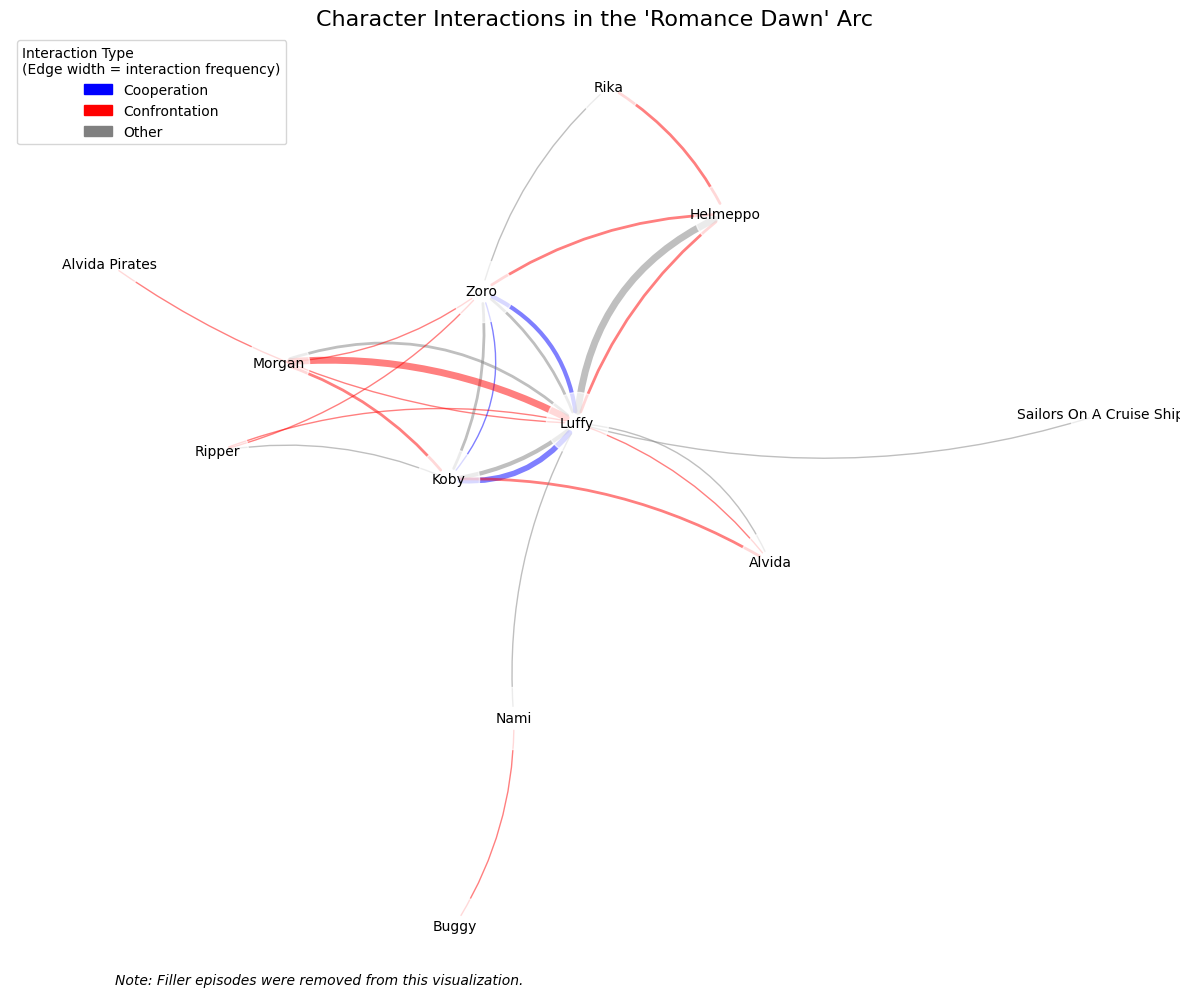

In [31]:
# Filtering the dataset to just Romance Dawn arc and removing filler episodes
rd_df = op_df.loc[(op_df['Arc'] == 'Romance Dawn') & (~op_df['Filler'])]
rd_df.loc[:, 'Interaction'] = rd_df['Interaction'].apply(lambda x: x if x in ['Cooperation', 'Confrontation'] else 'Other')

# Intializing the graph
rd_graph = nx.from_pandas_edgelist(
    rd_df,
    source = 'Character 1',
    target = 'Character 2',
    edge_attr = ['Interaction', 'Saga', 'Arc']
)

# Set up the figure size
plt.figure(figsize=(12, 10))

# Choose a layout for better node separation
pos = nx.spring_layout(rd_graph, k=0.7, iterations=50) 

# Count interaction frequencies between each pair for weighting
edge_weights = {}
for idx, row in rd_df.iterrows():
    pair = tuple(sorted([row['Character 1'], row['Character 2']]))
    edge_weights[pair] = edge_weights.get(pair, 0) + 1

# Assign edge colors and weights based on the 'Interaction' attribute and frequency
# For each unique pair, check all interactions and draw multi-edges with correct color and width
# Collect all interactions and their counts for each pair
pair_interactions = defaultdict(lambda: defaultdict(int))
for idx, row in rd_df.iterrows():
    pair = tuple(sorted([row['Character 1'], row['Character 2']]))
    interaction = row['Interaction']
    pair_interactions[pair][interaction] += 1

# Draw each interaction as a separate edge (multi-edges)
for pair, interactions in pair_interactions.items():
    u, v = pair
    # Offset for parallel edges
    offset = 0
    for interaction, count in interactions.items():
        if interaction == 'Cooperation':
            color = 'blue'
        elif interaction == 'Confrontation':
            color = 'red'
        else:
            color = 'gray'
        # Draw parallel edges with slight offset for visibility
        nx.draw_networkx_edges(
            rd_graph, pos,
            edgelist=[(u, v)],
            width=count,
            alpha=0.5,
            edge_color=color,
            arrows=True,  # Add this to use FancyArrowPatches and enable connectionstyle
            connectionstyle=f'arc3,rad={0.15 + offset}'
        )
        offset += 0.15

# Draw nodes and labels
nx.draw_networkx_nodes(rd_graph, pos, node_size=2000, node_color='white', alpha=0.7)
nx.draw_networkx_labels(rd_graph, pos, font_size=10, font_family='sans-serif')

# Add title
plt.title("Character Interactions in the 'Romance Dawn' Arc", size=16)

# Add legend for edge colors and note about edge width
legend_handles = [
    mpatches.Patch(color='blue', label='Cooperation'),
    mpatches.Patch(color='red', label='Confrontation'),
    mpatches.Patch(color='gray', label='Other')
]
plt.legend(handles=legend_handles, title="Interaction Type\n(Edge width = interaction frequency)", loc='upper left')
plt.axis('off')
plt.tight_layout()

# Add footnote
plt.figtext(0.1, 0.01, "Note: Filler episodes were removed from this visualization.", ha="left", fontsize=10, style='italic')

plt.show()

## Step 2: Calculate degree centrality and eigenvector centrality


Next, we calculate degree centrality of each node/character using `NetworkX.degree()` and the eigenvector centrality using `NetworkX.eigenvector_centrality()`. 

In [37]:
# Intializing the full graph
op_graph = nx.from_pandas_edgelist(
    op_df,
    source = 'Character 1',
    target = 'Character 2',
    edge_attr = ['Episode', 'Interaction', 'Saga', 'Arc']
)

# Compute degree centrality
deg = nx.degree(op_graph)
# Sort the degree by value (number of connections), descending
sorted_deg = sorted(deg, key=lambda x: x[1], reverse=True)
print("\nTop 10 Characters by Degree Centrality (Number of Connections):")
sorted_deg[0:10] # Show the top 10 characters by degree


Top 10 Characters by Degree Centrality (Number of Connections):


[('Luffy', 640),
 ('Sanji', 309),
 ('Zoro', 299),
 ('Straw Hat Pirates', 287),
 ('Nami', 265),
 ('Usopp', 237),
 ('Robin', 195),
 ('Chopper', 186),
 ('Franky', 167),
 ('Marine', 153)]

In [39]:
# Compute Eigenvector Centrality
eigen_centrality = nx.eigenvector_centrality(op_graph)
# Sort by centrality value, descending
sorted_eigen = sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 Characters by Eigenvector Centrality:")
sorted_eigen[0:10] # Show the top 10 characters by eigenvector central


Top 10 Characters by Eigenvector Centrality:


[('Luffy', 0.34342575311598356),
 ('Straw Hat Pirates', 0.22986277208587652),
 ('Zoro', 0.21984796124717118),
 ('Sanji', 0.2115375356463732),
 ('Nami', 0.20892038019745154),
 ('Usopp', 0.18430369995435641),
 ('Robin', 0.1615308174208919),
 ('Chopper', 0.16094110301701806),
 ('Franky', 0.13965226136755607),
 ('Marine', 0.1373044286847722)]

We see the same characters appear in the top 10 for both degree and eigenvector centrality. However, the Straw Hat Pirates rank higher in the eigenvector centrality list, suggesting that they are more connected to other well-connected characters in the network.

## Step 3: Compare centrality measures across Saga, Arc, and Interaction type



Determine main characters in each saga and arc: 
- By comparing degree centrality scores we can find out who the main characters are in each saga and arc and how they interact with other main characters.
- By comparing the degree centrality scores across `Interaction`, we can see how characters rely on different communication styles.

## Presentation Video

Link to presentation video: [insert].